In [43]:
%matplotlib inline
import openmc
import matplotlib.pyplot as plt
import numpy as np

In [44]:
# Materials definition

fuel = openmc.Material(name='Fuel Kernel') #tpcu
fuel.add_nuclide('U235', 0.155)
fuel.add_nuclide('U238', 0.845)
fuel.add_element('C', 0.5)
fuel.add_element('O', 1.5)
fuel.set_density('g/cm3', 10.5)
fuel.temperature = 1200


buffer = openmc.Material(name='Buffer Layer')
buffer.add_element('C', 1.0)
buffer.set_density('g/cm3', 1)
buffer.add_s_alpha_beta('c_Graphite')
buffer.temperature = 1200

IPyC = openmc.Material(name='Inner PyC Layer')
IPyC.add_element('C', 1.0)
IPyC.set_density('g/cm3', 1.9)
IPyC.add_s_alpha_beta('c_Graphite')
IPyC.temperature = 1200

SiC = openmc.Material(name = "SiC Layer")
SiC.add_element("Si", 1)
SiC.add_element("C", 1)
SiC.set_density("g/cm3", 3.2)
SiC.temperature = 1200

OPyC = openmc.Material(name='Outer PyC Layer')
OPyC.add_element('C', 1.0)
OPyC.set_density('g/cm3', 1.9)
OPyC.add_s_alpha_beta('c_Graphite') 
OPyC.temperature = 1200

graphite = openmc.Material(name='Graphite')
graphite.add_element('C', 1.0)
graphite.set_density('g/cm3', 1.85)
graphite.add_s_alpha_beta('c_Graphite')
graphite.temperature = 800


helium = openmc.Material(name='Helium')
helium.add_element('He', 1.0)
helium.set_density('g/cm3', 0.0051)
helium.temperature = 900


b4c = openmc.Material(name='B4C Poison')
b4c.add_element('B', 4.0, enrichment=10, enrichment_target='B10', enrichment_type='wo')
b4c.add_element('C', 1.0)
b4c.set_density('g/cm3', 2.52)
b4c.temperature = 1200









# Instantiate a Materials collection and export to xml
materials_list = [fuel, buffer, IPyC, SiC, OPyC, graphite, helium,
                  b4c]
materials_file = openmc.Materials(materials_list)
materials_file.export_to_xml()







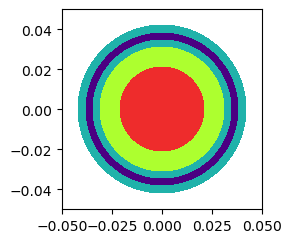

In [46]:
# Geometry definitions for TRISO particles

kernelsph = openmc.Sphere(r=0.02125)
buffsph = openmc.Sphere(r=0.03125)
IPyCsph = openmc.Sphere(r=0.03475)
SiCsph = openmc.Sphere(r=0.03825)
OPyCsph = openmc.Sphere(r=0.04225)

layers = [kernelsph, buffsph, IPyCsph, SiCsph, OPyCsph]
triso_mats = [fuel, buffer, IPyC, SiC, OPyC]
triso_cells = []
for i in range(5):
  if (i == 0):
    triso_cells.append(openmc.Cell(fill=triso_mats[0], region=-layers[0]))
  else:
    triso_cells.append(openmc.Cell(fill=triso_mats[i], region=+layers[i-1] & -layers[i]))

triso_universe = openmc.Universe(cells=triso_cells)
triso_colors = {triso_cells[0]: (238,44,44), triso_cells[1]: (173,255,47), 
                triso_cells[2]: (32,178,170), triso_cells[3]: (75,0,130), 
                triso_cells[4]: (32,178,170)}
triso_universe.plot(width = (0.1, 0.1), colors = triso_colors,)
plt.savefig('Reference triso.png', format='png', dpi=1200)


In [4]:
# Generating TRISO particle lattice in cylindrical pin cell

cylsurf = openmc.ZCylinder(r=0.6225)
maxz = openmc.ZPlane(z0=(79.3/2), boundary_type='reflective')
minz = openmc.ZPlane(z0=-(79.3/2), boundary_type='reflective')

lattice_region = -cylsurf & -maxz & +minz
triso_outer_radius = 0.04225
spheres = openmc.model.pack_spheres(radius=triso_outer_radius, region=lattice_region, pf=0.30)



triso_particles = [openmc.model.TRISO(triso_outer_radius, fill=triso_universe, center=c) for c in spheres]


vol_triso = 4/3 * 3.14 * triso_outer_radius**3 * len(triso_particles)




lattice_cell = openmc.Cell(region=lattice_region)
lower_left, upp_right = lattice_cell.region.bounding_box
shape = (4, 4, 4)
pitch = (upp_right - lower_left)/shape
triso_latt = openmc.model.create_triso_lattice(triso_particles, lower_left, pitch, shape, graphite)
lattice_cell.fill = triso_latt

lattice_universe = openmc.Universe(cells=[lattice_cell])


#lattice_universe.plot(width=(1.8, 1.8), color_by='material', colors = {graphite: (97, 97, 97),fuel: (238, 59, 59)})


In [5]:
# Creating coolant cells
small_coolant_surf = openmc.ZCylinder(r=0.635)
big_coolant_surf = openmc.ZCylinder(r=0.794)

small_coolant_cell = openmc.Cell(region=-small_coolant_surf & -maxz & +minz, fill=helium)
big_coolant_cell = openmc.Cell(region=-big_coolant_surf & -maxz & +minz, fill=helium)

outside_small_cell = openmc.Cell(region=+small_coolant_surf & -maxz & +minz, fill=graphite)
outside_big_cell = openmc.Cell(region=+big_coolant_surf & -maxz & +minz, fill=graphite)

scu = openmc.Universe(cells=[small_coolant_cell, outside_small_cell]) # scu means small coolant universe
bcu = openmc.Universe(cells=[big_coolant_cell, outside_big_cell])     # bcu means big coolant universe



In [6]:
poison_surf = openmc.ZCylinder(r=0.5715)
poison_cell = openmc.Cell(region=-poison_surf & -maxz & +minz, fill=b4c)
outside_poison_cell = openmc.Cell(region=+poison_surf & -maxz & +minz, fill=graphite)

pu = openmc.Universe(cells=[poison_cell, outside_poison_cell]) # pu means poison universe


In [7]:
outer_pin_region = +cylsurf & -maxz & +minz
outer_pin_cell = openmc.Cell(fill=graphite, region=outer_pin_region)

tpcu = openmc.Universe(cells=[lattice_cell, outer_pin_cell]) # tpcu means total pin cell universe



In [8]:
outer_graphite_cell = openmc.Cell(fill=graphite)
ogu = openmc.Universe(cells=[outer_graphite_cell]) # ogu means outer graphite universe


In [9]:
# Construct geometry of the hexagonal fuel assembly
# ogu, tpcu, pu, scu, bcu
# outer_graphite_universe, total_pin_cell_universe, poison_universe, small_coolant_universe, big_coolant_universe

assemblylat = openmc.HexLattice(name="Assembly")
assemblylat.outer = ogu
assemblylat.pitch = (1.8796,)
assemblylat.center = (0.0, 0.0)
assemblylat.orientation = 'x'

outer_ring = ([ogu, tpcu, bcu] + [tpcu, tpcu, bcu]*2 + [tpcu])*2   +   ([ogu, tpcu] + [bcu, tpcu, tpcu]*2 + [bcu, tpcu])*4

ring_1 = ([bcu, tpcu, tpcu]*3)*6

ring_2 = ([tpcu] + [bcu, tpcu, tpcu]*2 + [bcu])*6

ring_3 = ([tpcu, tpcu, bcu]*2 + [tpcu])*6

ring_4 = ([bcu, tpcu, tpcu]*2)*6 

ring_5 = [tpcu, bcu, tpcu, tpcu, bcu]*6

ring_6 = [tpcu, tpcu, bcu, tpcu]*6 

ring_7 = [bcu, tpcu, tpcu]*6

ring_8 = [tpcu, scu]*6 

ring_9 = [ogu]*6 

inner_ring = [ogu]

assemblylat.universes = [outer_ring,
                     ring_1,
                     ring_2,
                     ring_3,
                     ring_4,
                     ring_5,
                     ring_6,
                     ring_7,
                     ring_8,
                     ring_9,
                     inner_ring]
print(assemblylat)


HexLattice
	ID             =	74
	Name           =	Assembly
	Orientation    =	x
	# Rings        =	11
	# Axial        =	None
	Center         =	(0.0, 0.0)
	Pitch          =	(1.8796,)
	Outer          =	73
	Universes      
                    73  72  70  72  72  70  72  72  70  72  73
                  72  70  72  72  70  72  72  70  72  72  70  72
                70  72  72  70  72  72  70  72  72  70  72  72  70
              72  72  70  72  72  70  72  72  70  72  72  70  72  72
            72  70  72  72  70  72  72  70  72  72  70  72  72  70  72
          70  72  72  70  72  72  70  72  72  70  72  72  70  72  72  70
        72  72  70  72  72  70  72  72  70  72  72  70  72  72  70  72  72
      72  70  72  72  70  72  72  70  72  72  70  72  72  70  72  72  70  72
    70  72  72  70  72  72  70  72  72  69  72  72  70  72  72  70  72  72  70
  72  72  70  72  72  70  72  72  69  73  73  69  72  72  70  72  72  70  72  72
73  70  72  72  70  72  72  70  72  73  73  73  72  70  72  72

In [10]:


assembly_surf = openmc.model.hexagonal_prism(edge_length=21, orientation='x', boundary_type='reflective')
assembly_cell = openmc.Cell(fill=assemblylat, region=assembly_surf & +minz & -maxz)
assembly_universe = openmc.Universe(cells=[assembly_cell])



In [11]:
# assembly_universe.plot(width=(50, 50), pixels = (1000, 1000), color_by='cell')

In [12]:
geom = openmc.Geometry(assembly_universe)
geom.export_to_xml()



In [13]:
# OpenMC simulation parameters

batches = 20
inactive = 5
particles = 5000


In [14]:
##############################################################################
#                   Exporting to OpenMC settings.xml file
##############################################################################

# Instantiate a Settings object, set all runtime parameters, and export to XML

settings_file = openmc.Settings()
settings_file.temperature = {
		 'method'    :'interpolation',
		 'tolerance' : 300.0
}
# settings_file.temperature = {'method':'interpolation'}
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
settings_file.output = {'tallies': True}

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-5, -5, -0.63, 5, 5, 0.63]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.Source(space=uniform_dist)


settings_file.export_to_xml()

In [15]:
# # Create equal-lethargy energies to put in filter

# energies = np.logspace(np.log10(1e-5), np.log10(20.0e6), 501)
# e_filter = openmc.EnergyFilter(energies)

# # Create tally with energy filter
# tally = openmc.Tally()
# tally.filters = [e_filter]
# tally.scores = ['flux']
# tallies = openmc.Tallies()
# tallies.append(tally, merge=True)
# tallies.export_to_xml()

In [16]:
# openmc.run()

In [17]:
import math
import openmc.deplete



fuel.volume = 4/3 * 3.1416 * 0.02125**3 * len(triso_particles) * 210

chain = openmc.deplete.Chain.from_xml("/home/razu/Downloads/chain_casl_pwr.xml")


model = openmc.Model(geometry=geom, settings=settings_file)
operator = openmc.deplete.CoupledOperator(model, "/home/razu/Downloads/chain_casl_pwr.xml")

# The power density is 113.1 MW/t-HM = 113.1 W/g
power = 113.1 * operator.heavy_metal

In [18]:


time_steps = [30] * 20

integrator = openmc.deplete.PredictorIntegrator(operator, time_steps, power, timestep_units='d')



In [19]:


# integrator.integrate()



In [20]:
!ls *.h5

depletion_results.h5	  openmc_simulation_n16.h5  openmc_simulation_n4.h5
openmc_simulation_n0.h5   openmc_simulation_n17.h5  openmc_simulation_n5.h5
openmc_simulation_n10.h5  openmc_simulation_n18.h5  openmc_simulation_n6.h5
openmc_simulation_n11.h5  openmc_simulation_n19.h5  openmc_simulation_n7.h5
openmc_simulation_n12.h5  openmc_simulation_n1.h5   openmc_simulation_n8.h5
openmc_simulation_n13.h5  openmc_simulation_n20.h5  openmc_simulation_n9.h5
openmc_simulation_n14.h5  openmc_simulation_n2.h5   statepoint.20.h5
openmc_simulation_n15.h5  openmc_simulation_n3.h5   summary.h5


In [21]:
results = openmc.deplete.Results("./depletion_results.h5")



time, k = results.get_keff()



time /= (24 * 60 * 60)  # convert back to days from seconds




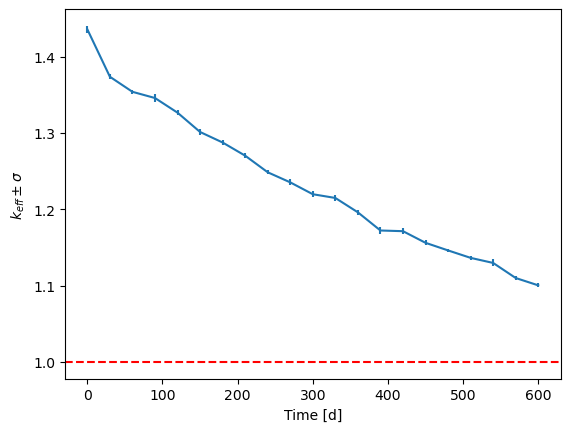

In [22]:

from matplotlib import pyplot



pyplot.errorbar(time, k[:, 0], yerr=k[:, 1])
pyplot.xlabel("Time [d]")
pyplot.ylabel("$k_{eff}\pm \sigma$");

pyplot.axhline(y = 1, color = 'r', linestyle = '--')

In [23]:
k

array([[1.43583183, 0.00448725],
       [1.37371081, 0.00330943],
       [1.35396548, 0.00287716],
       [1.3458307 , 0.00477347],
       [1.32663623, 0.00313793],
       [1.30132494, 0.00354825],
       [1.28754087, 0.0033172 ],
       [1.27027125, 0.00366998],
       [1.24852989, 0.00271638],
       [1.2353005 , 0.00400277],
       [1.21975913, 0.00376195],
       [1.21486012, 0.00441856],
       [1.19601969, 0.00329942],
       [1.17222141, 0.00445638],
       [1.17132468, 0.00372366],
       [1.15608646, 0.00343722],
       [1.14611452, 0.00224581],
       [1.13636404, 0.00219858],
       [1.12970343, 0.00460868],
       [1.10995611, 0.00206863],
       [1.10034402, 0.00270867]])

In [24]:

k_only_triso = []
for i in range(0,len(k),1):
     k_only_triso.append(k[i][0])
print(k_only_triso)
len(k_only_triso)

[1.4358318297757224, 1.37371081236868, 1.353965480264429, 1.3458306977484678, 1.3266362310804394, 1.3013249350794753, 1.2875408664388894, 1.27027124610931, 1.2485298862929712, 1.235300495026237, 1.2197591276170787, 1.2148601157460983, 1.1960196879490672, 1.172221409717278, 1.1713246826264605, 1.156086457181639, 1.14611452081298, 1.1363640364864036, 1.1297034262270191, 1.1099561087664853, 1.1003440165686673]


21

In [25]:

print(operator.heavy_metal)
print(operator.heavy_metal/1000)

fuel_loading = operator.heavy_metal
print(fuel_loading)

7213.9945582232485
7.2139945582232485
7213.9945582232485


In [26]:
burnup = (power * 10**(-6))*time/(fuel_loading/1000)
print(burnup)

[ 0.     3.393  6.786 10.179 13.572 16.965 20.358 23.751 27.144 30.537
 33.93  37.323 40.716 44.109 47.502 50.895 54.288 57.681 61.074 64.467
 67.86 ]


In [27]:


_, u235 = results.get_atoms("1", "U235")
_, xe135 = results.get_atoms("1", "Xe135")
_, pu239 = results.get_atoms("1", "Pu239")



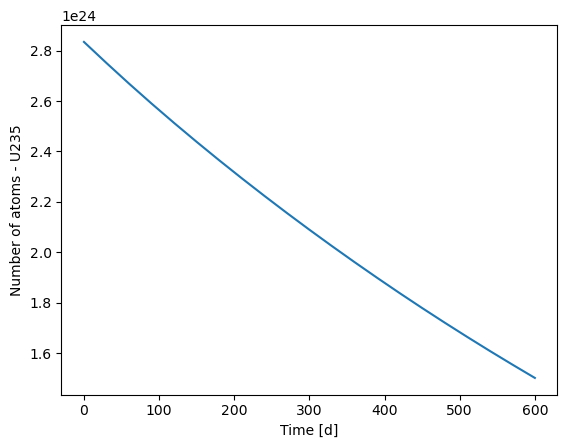

In [28]:


pyplot.plot(time, u235, label="U235")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - U235");



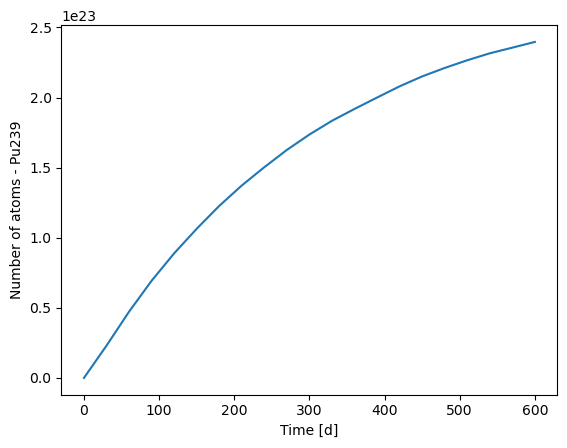

In [29]:
pyplot.plot(time, pu239, label="Pu239")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Pu239");

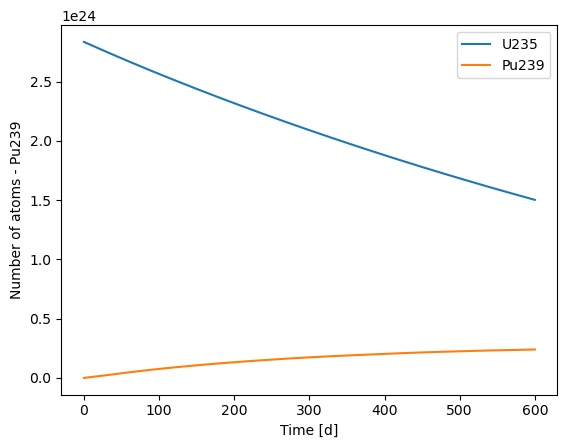

In [30]:

pyplot.plot(time, u235, label="U235")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - U235");

pyplot.plot(time, pu239, label="Pu239")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Pu239");

pyplot.legend()

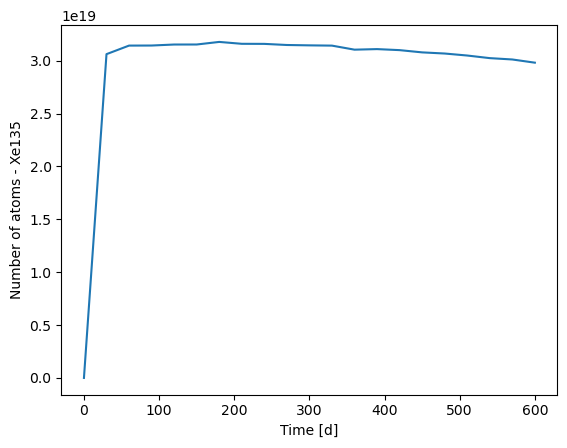

In [31]:


pyplot.plot(time, xe135, label="Xe135")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Xe135");



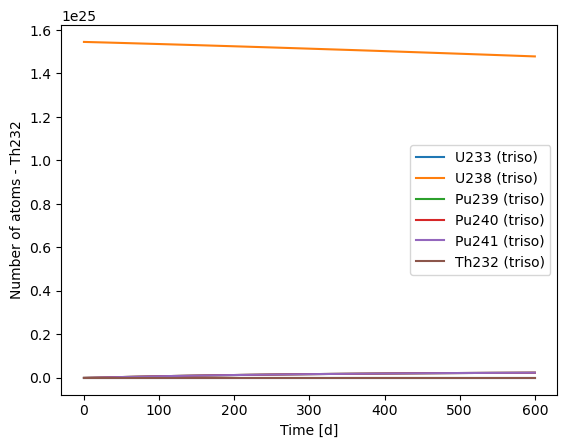

In [34]:

#fissile
_, u235 = results.get_atoms("1", "U235")
_, u233 = results.get_atoms("1", "U233")


_, pu239 = results.get_atoms("1", "Pu239")
_, pu241 = results.get_atoms("1", "Pu239")

#poisons
_, xe135 = results.get_atoms("1", "Xe135")
_, sm149 = results.get_atoms("1", "Sm149")



#fertile
_, th232 = results.get_atoms("1", "Th232")
_, u238 = results.get_atoms("1", "U238")
_, pu240 = results.get_atoms("1", "Pu239")

# _, u235_10 = results.get_atoms("10", "U235")
# _, xe135_10 = results.get_atoms("10", "Xe135")
# _, pu239_10 = results.get_atoms("10", "Pu239")


# #for deplete materials

# #fissile
# _, u235_10 = results.get_atoms("10", "U235")
# _, u233_10 = results.get_atoms("10", "U233")


# _, pu239_10 = results.get_atoms("10", "Pu239")
# _, pu241_10= results.get_atoms("10", "Pu239")

# #poisons
# _, xe135_10 = results.get_atoms("10", "Xe135")
# _, sm149_10 = results.get_atoms("10", "Sm149")



# #fertile
# _, th232_10 = results.get_atoms("10", "Th232")
# _, u238_10 = results.get_atoms("10", "U238")
# _, pu240_10 = results.get_atoms("10", "Pu239")

# pyplot.plot(time, u235, label="U235 (triso)")
# pyplot.xlabel("Time [d]")
# pyplot.ylabel("Number of atoms - U235");


pyplot.plot(time, u233, label="U233 (triso)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - U233");

pyplot.plot(time, u238, label="U238 (triso)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - U238");

pyplot.plot(time, pu239, label="Pu239 (triso)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Pu239");

pyplot.plot(time, pu240, label="Pu240 (triso)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Pu240");

pyplot.plot(time, pu241, label="Pu241 (triso)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Pu241");

pyplot.plot(time, th232, label="Th232 (triso)")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Th232");
pyplot.legend()





In [42]:
print(u233)


print(u235)


print(u238)


print(pu239)


print(pu240)


print(pu241)


print(xe135)


print(sm149)





[7.73814104e+05 2.75225374e+14 1.18539044e+15 2.67351764e+15
 2.66329914e+15 2.96401158e+15 3.56872163e+15 3.83011132e+15
 4.39692212e+15 4.92733735e+15 5.65078014e+15 5.87591203e+15
 7.36056618e+15 8.10190513e+15 8.46379904e+15 9.01756173e+15
 9.38637801e+15 9.98640549e+15 1.06853096e+16 1.10330567e+16
 1.09734176e+16]
[2.83426137e+24 2.75053454e+24 2.66890968e+24 2.58973105e+24
 2.51282051e+24 2.43794186e+24 2.36485510e+24 2.29362955e+24
 2.22404770e+24 2.15604185e+24 2.08961439e+24 2.02472252e+24
 1.96124167e+24 1.89919362e+24 1.83843341e+24 1.77911247e+24
 1.72117207e+24 1.66453286e+24 1.60907628e+24 1.55497661e+24
 1.50195200e+24]
[1.54512959e+25 1.54234778e+25 1.53941224e+25 1.53640539e+25
 1.53338741e+25 1.53033250e+25 1.52716711e+25 1.52398681e+25
 1.52077605e+25 1.51746846e+25 1.51414207e+25 1.51077917e+25
 1.50744088e+25 1.50398263e+25 1.50041919e+25 1.49683672e+25
 1.49324662e+25 1.48960196e+25 1.48592528e+25 1.48224041e+25
 1.47847319e+25]
[7.73814104e+05 2.30146193e+22 4.7

[2.62431092e+16 2.54921848e+16 2.47191809e+16 2.40001404e+16
 2.33555017e+16 2.27521863e+16 2.21783857e+16 2.16476326e+16
 2.11546130e+16 2.06549289e+16 2.01639698e+16 1.97435562e+16
 1.92846784e+16 1.88709422e+16 1.84266875e+16 1.79962740e+16
 1.75928127e+16 1.72240572e+16 1.68049808e+16 1.64772566e+16
 1.60891964e+16]


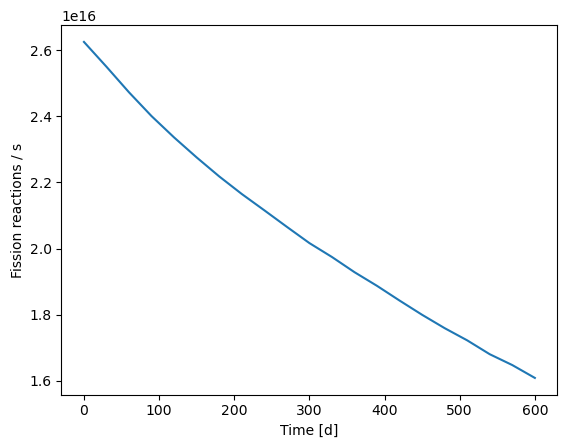

In [36]:
_, u235_fission = results.get_reaction_rate("1", "U235", "fission")


pyplot.plot(time, u235_fission)
pyplot.xlabel("Time [d]")
pyplot.ylabel("Fission reactions / s");

fission_reaction_rate= u235_fission
print(fission_reaction_rate)

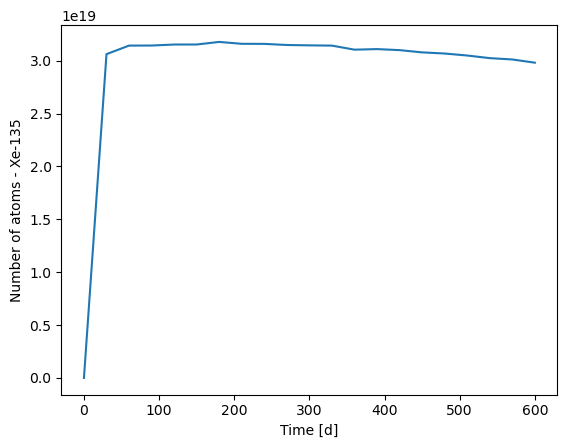

In [37]:
pyplot.plot(time, xe135, label="Xe-135")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Xe-135");

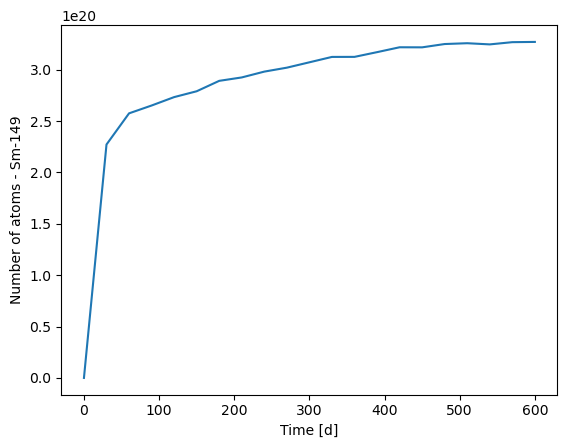

In [38]:
pyplot.plot(time, sm149, label="Sm-149")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Sm-149");